# Component inference and model families 

This notebook shows a series of examples of how to use model families and component inference with PCM.

In [1]:
# Import necessary libraries
import PcmPy as pcm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import scipy.io as io

## Example 1: Simple 3 x 2 Design
This is a classical example of a fully crossed design with two factors (A and B) and the possibility for an interaction between those two factors. In this MANOVA-like design it is whether you orthogonalize the interaction and main effects when building the features for the 3 different components. If the interaction is not orthogonalized, the interaction effect can explain part of the variance explained by the main effects - you will see the BF for the interaction effect increasing and for the main effect decreasing. If it is orthogonalized, it is restricted to true interactions between the two factors. 

#### Generating data from a 3x2 Design
Note that for data generation, we consider the interaction fixed - meaning that when the interaction effect is present, no difference between categories of A and B occur. 

In [3]:
# Generate the three model components, each one as a fixed model
A = np.array([[1.0,0,0],[1,0,0],[0,1,0],[0,1,0],[0,0,1],[0,0,1]])
B = np.array([[1.0,0],[0,1],[1,0],[0,1],[1,0],[0,1]])
I = np.eye(6)
# Orthogonalize the interaction effect
X= np.c_[A,B]
Io = I-X @ np.linalg.pinv(X) @ I

# Now Build the second moment matrix and create the full model 
# For data generation: 
Gc = np.zeros((3,6,6))
Gc[0]=A@A.T
Gc[1]=B@B.T
Gc[2]=Io@Io.T

trueModel = pcm.ComponentModel('A+B+I',Gc)


In [3]:
# Now generate 20 data set from the full model 
[cond_vec,part_vec]=pcm.sim.make_design(6,8)
D = pcm.sim.make_dataset(trueModel,np.array([-np.inf,-1,0]),
        signal=0.1,
        n_sim = 20,
        n_channel=20,part_vec=part_vec,
        cond_vec=cond_vec)
    

#### Building a model family

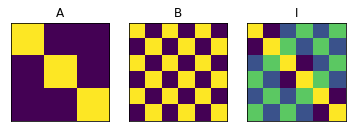

In [6]:
# Then construct a model family of all possible combinations 
# Here you can decide whether to orthogonalize the interaction effect or not
Gc[2]=Io@Io.T
MF=pcm.model.ModelFamily(Gc,comp_names=['A','B','I'])

# Show the three model components
for i in range(3):
    ax = plt.subplot(1,3,i+1)
    plt.imshow(Gc[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title(MF.comp_names[i])

#### Fitting the data 
Now we can fit the data with the entire model family. An intercept is added as a fixed effect for each partition (block) seperately, as common for fMRI data. The result is a likelihood for each of the model combination. 

<AxesSubplot:xlabel='model', ylabel='Log Bayes Factor'>

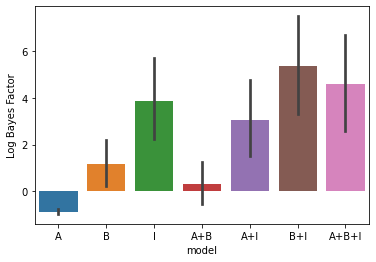

In [7]:
# Fit the data and display the relative likelihood. 
T,theta=pcm.fit_model_individ(D,MF,verbose=False,fixed_effect='block', fit_scale=False)
# Here we correcting for the number of parameters (using AIC)
pcm.vis.model_plot(T.likelihood-MF.num_comp_per_m)

#### Inference: Model posterior
For the inference, we can use either crossvalidated pseudo-likelihoods (within- subject or between subjects - see inference), or we can use the fitted likelihood, correcting for the number of paramaters using an AIC approach. We use latter approach here. 

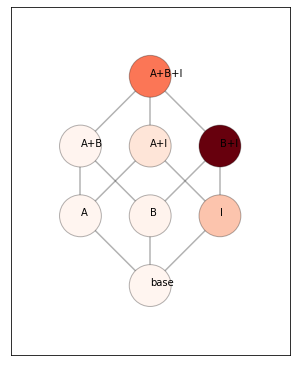

In [8]:
# We can computer the posterior probability of each of the mixture models. 
# This uses the flat prior over all possible model combinations 
# The whole model family can visualized as a model tree.  
plt.figure(figsize=(5,7))
# Get the mean likelihood 

mposterior = MF.model_posterior(T.likelihood.mean(axis=0),method='AIC',format='DataFrame')
pcm.vis.plot_tree(MF,mposterior,show_labels=True,show_edges=True)
# mposterior.to_numpy()

#### Inference: Component posterior
We can also get the posterior probability for each component. This is simply the sum of the posterior probabilties of all the model combinations that contain that component. The 0.5 line (this is the prior probability) is drawn. The lower line is the most evidence we can get for the absence of a model component using AIC. This is because, in the worst case, a new component does not increase the likelihood at all. This would result in the new component having a realtive likelihood that is 1.0 lower than the simpler model (parameter penality). Thus, overall the worst we can get p=1/(1+exp(1)).

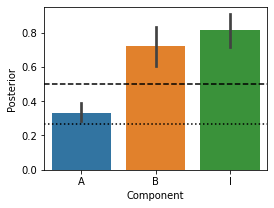

In [7]:

# Component posterior
plt.figure(figsize=(4,3))
cposterior = MF.component_posterior(T.likelihood,method='AIC',format='DataFrame')
pcm.vis.plot_component(cposterior,type='posterior')


#### Component Bayes factor 
For frequentist statistical testing and display, it is also often useful use the log-odds of the posterior $log(p/(1-p))$. For a flat prior across the model family, this is the bayes factor for the specific component. 

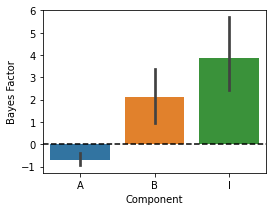

In [8]:
# Component Bayes Factor 
plt.figure(figsize=(4,3))
c_bf = MF.component_bayesfactor(T.likelihood,method='AIC',format='DataFrame')
pcm.vis.plot_component(c_bf,type='bf')

#### Model family with base components

All models have base components. If not passed to the function, the base componet will be zero model (second-moment with not structure)
In this example in simulation I set the weights of the interaction and basecomponent to non zero. If we don't add the basecomponent in the model family, you can see that the inference would also go in favor of the model that has large correlation with base component in this example, A. However, modeling the base component can solve this issue.

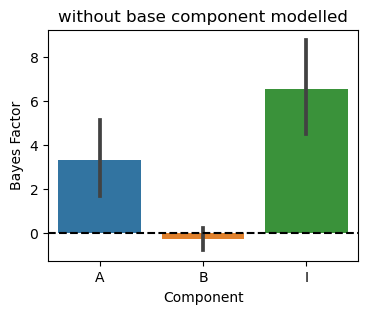

In [22]:
basecomp = np.zeros((1,6,6))
basecomp[0] = np.block([[np.ones((3,3)),np.zeros((3,3))],[np.zeros((3,3)),np.ones((3,3))]])

trueModel = pcm.ComponentModel('A+B+I+basecomponent',np.r_[Gc,basecomp])


# Now generate 20 data set from the full model 
[cond_vec,part_vec]=pcm.sim.make_design(6,8)
D = pcm.sim.make_dataset(trueModel,np.array([-np.inf,-np.inf,0,0]),
        signal=0.1,
        n_sim = 20,
        n_channel=20,part_vec=part_vec,
        cond_vec=cond_vec)


MF=pcm.model.ModelFamily(Gc,comp_names=['A','B','I'])
# Fit the data and display the relative likelihood. 
T,theta=pcm.fit_model_individ(D,MF,verbose=False,fixed_effect='block',fit_scale=False)

# Component Bayes Factor
plt.figure(figsize=(4,3))
plt.title('without base component modelled')
c_bf = MF.component_bayesfactor(T.likelihood,method='AIC',format='DataFrame')
pcm.vis.plot_component(c_bf,type='bf')

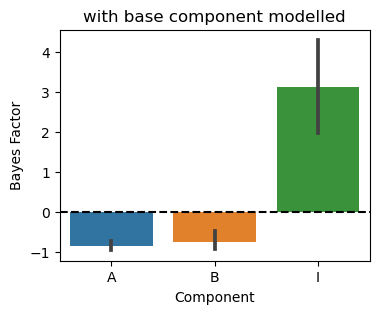

In [23]:
MF=pcm.model.ModelFamily(Gc,comp_names=['A','B','I'],basecomponents=basecomp)
# Fit the data and display the relative likelihood. 
T,theta=pcm.fit_model_individ(D,MF,verbose=False,fixed_effect='block',fit_scale=False)

# Component Bayes Factor
plt.figure(figsize=(4,3))
plt.title('with base component modelled')
c_bf = MF.component_bayesfactor(T.likelihood,method='AIC',format='DataFrame')
pcm.vis.plot_component(c_bf,type='bf')

## Example 2: Random example with 5 partly co-linear representations
In this example, we provide an example with random components that are partly overlapping with each other. 
We also provide a function that performs different forms of component inference.

In [9]:
# Another function that makes a random feature model 
# using Q feature groups (components), each consisting of num_feat features. 
def random_design(N=10,Q=5,num_feat=2,seed=1):
    Gc = np.empty((Q,N,N))
    rng = np.random.default_rng(seed)
    for q in range(Q):
        X= rng.normal(0,1,(N,num_feat))
        X = X/np.sqrt(np.sum(X**2,axis=0))
        Gc[q,:,:]= X @ X.T
    M = pcm.ComponentModel('full',Gc)
    MF=pcm.model.ModelFamily(Gc)
    return M,MF

In [10]:
def component_inference(D,MF):
    T,theta=pcm.fit_model_individ(D,MF,verbose=False)

    # pcm.vis.model_plot(T.likelihood-MF.num_comp_per_m)
    mposterior = MF.model_posterior(T.likelihood.mean(axis=0),method='AIC',format='DataFrame')
    cposterior = MF.component_posterior(T.likelihood,method='AIC',format='DataFrame')
    c_bf = MF.component_bayesfactor(T.likelihood,method='AIC',format='DataFrame')

    fig=plt.figure(figsize=(18,3.5))
    plt.subplot(1,3,1)
    pcm.vis.plot_tree(MF,mposterior,show_labels=False,show_edges=True)
    ax=plt.subplot(1,3,2)
    pcm.vis.plot_component(cposterior,type='posterior')
    ax=plt.subplot(1,3,3)
    pcm.vis.plot_component(c_bf,type='bf')


Now we make an example with 5 component and 10 conditions...

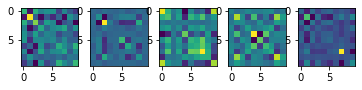

In [11]:
# make and plot a random design 
N = 10
Q = 5
M,MF = random_design(N=N,Q=Q,seed=1)
for q in range(Q):
        plt.subplot(1,Q,q+1)
        plt.imshow(M.Gc[q,:,:])


In [12]:
# Let's check the co-linearity of these particular components by looking at their correlation 
GG = np.reshape(M.Gc,(Q,-1)) # Flatten out 
np.corrcoef(GG)

array([[1.        , 0.24581198, 0.05609763, 0.3498265 , 0.42614867],
       [0.24581198, 1.        , 0.10612771, 0.20962178, 0.24458923],
       [0.05609763, 0.10612771, 1.        , 0.05158634, 0.3199829 ],
       [0.3498265 , 0.20962178, 0.05158634, 1.        , 0.15116567],
       [0.42614867, 0.24458923, 0.3199829 , 0.15116567, 1.        ]])

In this example, component 2 and 3 are relatively uncorrelated

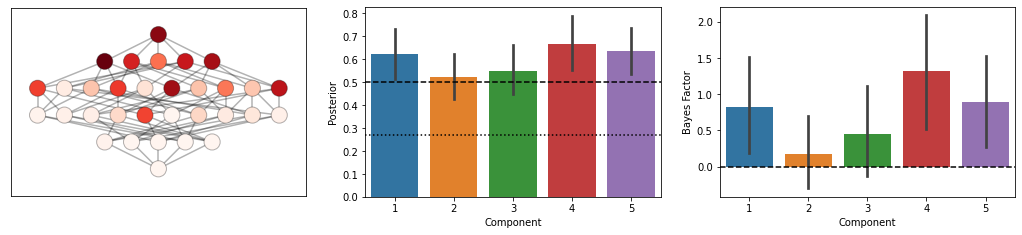

In [16]:
# Now make artifical data and plot component inference 
# In this example, component 1 and 4 are not present 
theta = np.array([-1,-1,-1,-1,-1])

[cond_vec,part_vec]=pcm.sim.make_design(N,8)
D = pcm.sim.make_dataset(M,theta,
                            signal=0.2,
                            n_sim = 20,
                            n_channel=20,part_vec=part_vec,
                            cond_vec=cond_vec)
component_inference(D,MF)
